<a href="https://colab.research.google.com/github/vladimbo/Bayesian/blob/master/DRLTRADER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-_gohrye4
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-_gohrye4
     |████████████████████████████████| 6.6MB 4.6MB/s 
     |████████████████████████████████| 1.6MB 43.5MB/s 
     |████████████████████████████████| 245kB 41.0MB/s 
     |████████████████████████████████| 110.5MB 90kB/s 
     |████████████████████████████████| 307kB 49.8MB/s 
     |████████████████████████████████| 12.4MB 30.6MB/s 
     |████████████████████████████████| 256kB 47.3MB/s 
     |████████████████████████████████| 583kB 40.8MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-j22zg15f/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-j22zg15f/pyfolio
     |████████████████████████████████| 5.5MB 30.5MB/s 
     |████████████████████████████████| 1.0MB 42.3MB/s 
     |████████████████████████████████| 

In [2]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas','numpy', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow','pyfolio'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
    !pip install git+https://github.com/quantopian/pyfolio

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [5]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [6]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [7]:
# from config.py end_date is a string
config.END_DATE

'2020-09-30'

In [9]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
df.shape

(88680, 7)

In [11]:
df.head()

,date,open,high,low,close,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,7.460152e+08,AAPL
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1.181608e+09,AAPL
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1.289310e+09,AAPL
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,7.530488e+08,AAPL
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,6.735008e+08,AAPL


In [12]:

df = FeatureEngineer(df,
                    use_technical_indicator=True,
                    use_turbulence=True).preprocess_data()

Successfully added technical indicators
Successfully added turbulence index


In [13]:
df.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0


In [14]:
train = data_split(df, config.START_DATE,config.START_TRADE_DATE)
trade = data_split(df,config.START_TRADE_DATE,config.END_DATE)

In [15]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0


In [16]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.249401,148158800.0,AAPL,-2.003499,37.867367,-91.588048,42.250808,119.879107
0,2019-01-02,93.910004,96.269997,93.769997,92.643311,4175400.0,AXP,-3.426008,41.204982,-97.742269,26.709417,119.879107
0,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200.0,BA,-5.550592,47.010000,-21.712382,13.611972,119.879107
0,2019-01-02,124.029999,127.879997,123.000000,119.302582,4783200.0,CAT,-0.686759,48.229089,-5.091209,0.873482,119.879107
0,2019-01-02,42.279999,43.200001,42.209999,40.382099,23833500.0,CSCO,-0.960061,44.872557,-87.496850,29.529377,119.879107


In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension

In [18]:
env_setup = EnvSetup(stock_dim = stock_dimension,
                        state_space = state_space,
                        hmax = 100,
                        initial_amount = 1000000,
                        transaction_cost_pct = 0.001)

In [19]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)

In [21]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade)

In [22]:
agent = DRLAgent(env = env_train)

In [23]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0007,
			  'verbose':0,
			  'timesteps':100000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), model_params = a2c_params_tuning)

==============Model Training===========




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



begin_total_asset:1000000
end_total_asset:3258525.497932022
total_reward:2258525.497932022
total_cost:  269935.818207872
total_trades:  73550
Sharpe:  0.9078300583455827

begin_total_asset:1000000
end_total_asset:4134521.4125368735
total_reward:3134521.4125368735
total_cost:  242150.70856307322
total_trades:  71811
Sharpe:  1.0491424691458957
begin_total_asset:1000000
end_total_asset:5017374.014098127
total_reward:4017374.0140981274
total_cost:  151577.50211207892
total_trades:  62470
Sharpe:  1.0771214051637177
begin_total_asset:1000000
end_total_asset:3039668.198101406
total_reward:2039668.1981

In [24]:
insample_turbulence = train.drop_duplicates(subset=['date'])

In [25]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       75.936149
std        38.178007
min         0.000000
25%        58.034373
50%        74.015054
75%        96.948888
max       230.256689
Name: turbulence, dtype: float64

In [26]:
insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [27]:
insample_turbulence_threshold

230.2566889369161

In [28]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade,
                                         turbulence_threshold=230) 

df_account_value, df_actions = DRLAgent.DRL_prediction(model=model_a2c,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

previous_total_asset:1000000
end_total_asset:898792.583162086
total_reward:-101207.41683791403
total_cost:  14312.315877304552
total trades:  5448
Sharpe:  -0.12260386444069803


In [29]:
df_account_value.shape

(440, 2)

In [30]:
df_account_value.head()

,date,account_value
0,2019-01-02,1.000000e+06
1,2019-01-03,9.960271e+05
2,2019-01-04,1.004654e+06
3,2019-01-07,1.005076e+06
4,2019-01-08,1.013182e+06


In [31]:
df_actions.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,100.000000,-100.000000,100.0,-100.000000,92.345062,-100.000000,23.390663,-78.259834,91.382172,-100.000000,61.936413,-100.000000,100.000000,10.137171,-100.000000,-100.0,-100.000000,100.0,100.000000,-100.000000,100.000000,100.000000,100.000000,-100.00000,42.546799,14.253962,100.000000,88.465706,-86.970383,100.000000
2019-01-03,-100.000000,-100.000000,100.0,-90.716446,14.965160,-100.000000,94.337723,96.836189,100.000000,-100.000000,32.965332,-14.661267,67.734894,-100.000000,-52.281006,-100.0,-93.834671,100.0,100.000000,-92.063255,100.000000,100.000000,100.000000,-100.00000,21.869463,-100.000000,98.162201,-33.433533,34.352581,100.000000
2019-01-04,100.000000,-100.000000,100.0,-100.000000,37.839676,-83.443001,23.880398,-100.000000,100.000000,-49.899792,-36.720131,-37.621658,59.643578,100.000000,23.459053,-100.0,35.581432,100.0,100.000000,-98.078087,100.000000,100.000000,-13.750898,-20.86718,63.940655,-100.000000,-34.106148,100.000000,89.610321,29.727262
2019-01-07,83.099129,71.759247,100.0,-100.000000,-50.125153,-51.848232,100.000000,-28.008621,74.155441,-37.641670,100.000000,-100.000000,100.000000,-51.132656,100.000000,-100.0,-100.000000,100.0,82.543633,-100.000000,100.000000,74.639549,39.026546,-100.00000,-61.389160,-100.000000,100.000000,100.000000,-9.106627,-3.613639
2019-01-08,-100.000000,83.951637,100.0,-59.922836,-100.000000,-100.000000,-1.133871,-100.000000,100.000000,-100.000000,100.000000,-71.908615,99.678627,-53.171074,-54.740215,-100.0,-81.893661,100.0,100.000000,60.795403,-51.590168,100.000000,100.000000,-100.00000,74.661949,-100.000000,100.000000,100.000000,9.046626,100.000000


In [32]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  -2.9894286154373395
sharpe ratio:  -0.12260386444069803
Annual return         -0.059282
Cumulative returns    -0.101207
Annual volatility      0.247532
Sharpe ratio          -0.122604
Calmar ratio          -0.181460
Stability              0.419352
Max drawdown          -0.326693
Omega ratio            0.977123
Sortino ratio         -0.164130
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.949447
Daily value at risk   -0.031307
Alpha                  0.000000
Beta                   1.000000
dtype: float64


==============Compare to S&P 500===========
annual return:  -2.9894286154373395
sharpe ratio:  -0.12260386444069803
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)


Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,-5.941%
Cumulative returns,-10.121%
Annual volatility,24.753%
Sharpe ratio,-0.12
Calmar ratio,-0.18
Stability,0.42
Max drawdown,-32.669%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.67,2019-09-18,2020-05-13,NaT,NaN
1,10.59,2019-07-23,2019-08-14,2019-09-10,36
2,9.47,2019-03-01,2019-05-31,2019-07-19,101
3,1.77,2019-01-18,2019-01-22,2019-01-30,9
4,1.72,2019-02-05,2019-02-11,2019-02-13,7


/usr/local/lib/python3.6/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


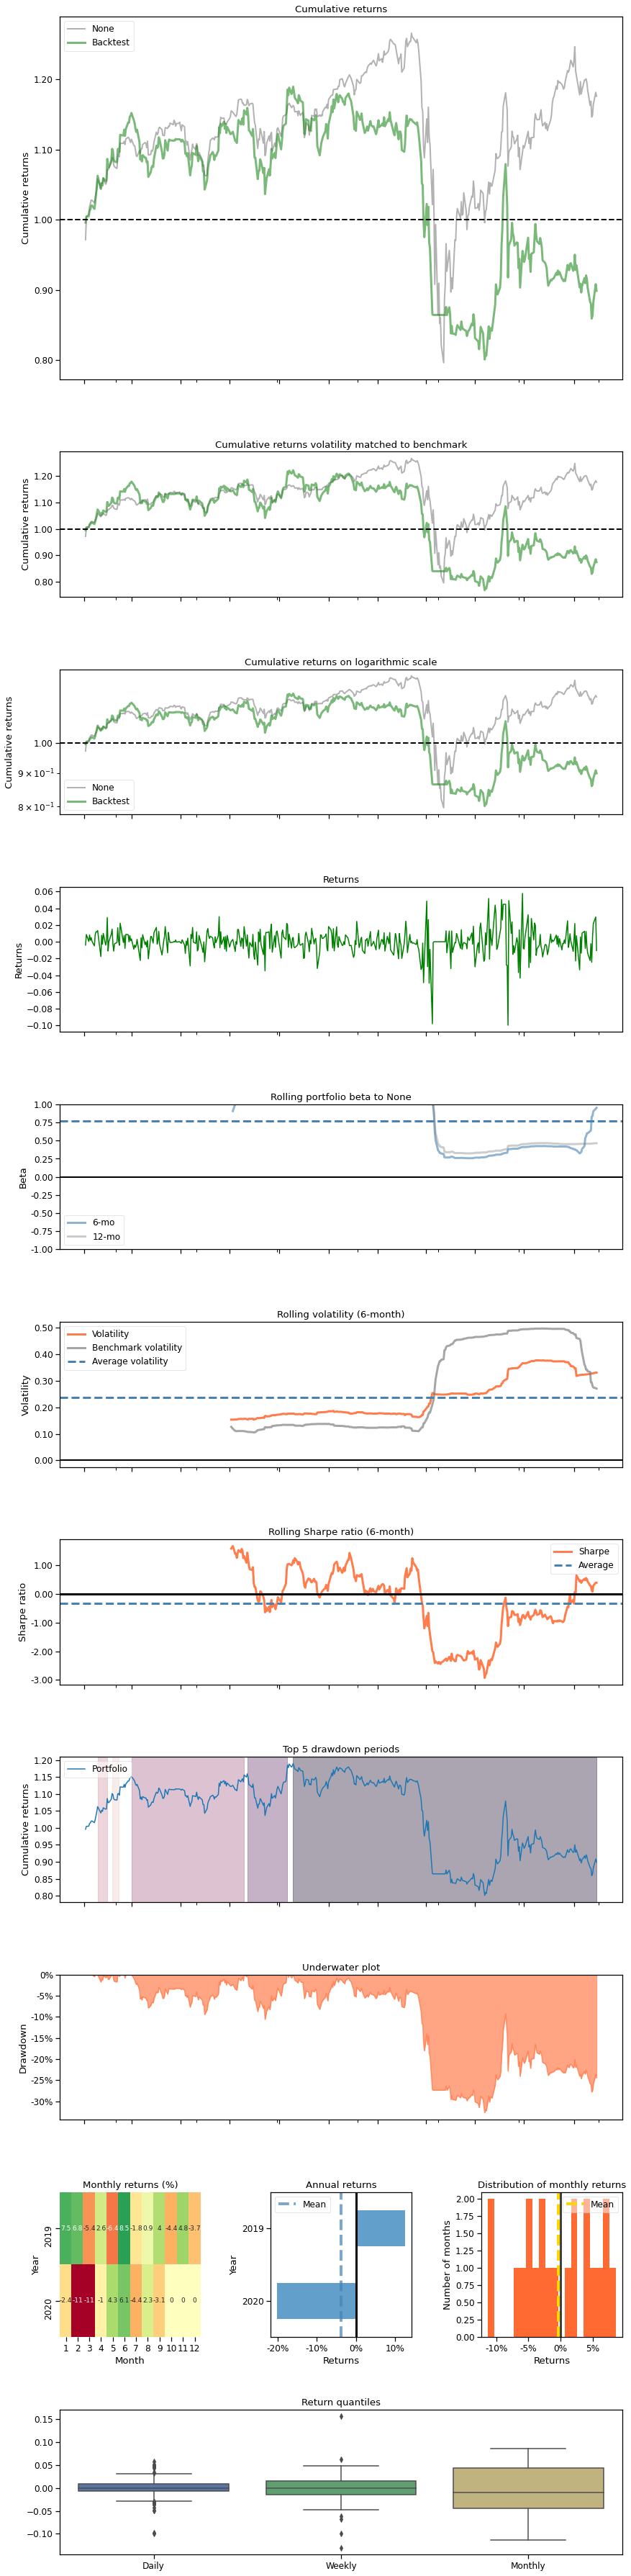

In [33]:
print("==============Compare to S&P 500===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, baseline_ticker = '^DJI')

In [34]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)
Annual return          0.097239
Cumulative returns     0.175892
Annual volatility      0.287173
Sharpe ratio           0.468543
Calmar ratio           0.262198
Stability              0.010261
Max drawdown          -0.370862
Omega ratio            1.110729
Sortino ratio          0.641939
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.807113
Daily value at risk   -0.035647
Alpha                  0.000000
Beta                   1.000000
dtype: float64
